Using built-in file: /Users/marekswoodside/Library/Caches/librosa/sorohanro_-_solo-trumpet-06.ogg


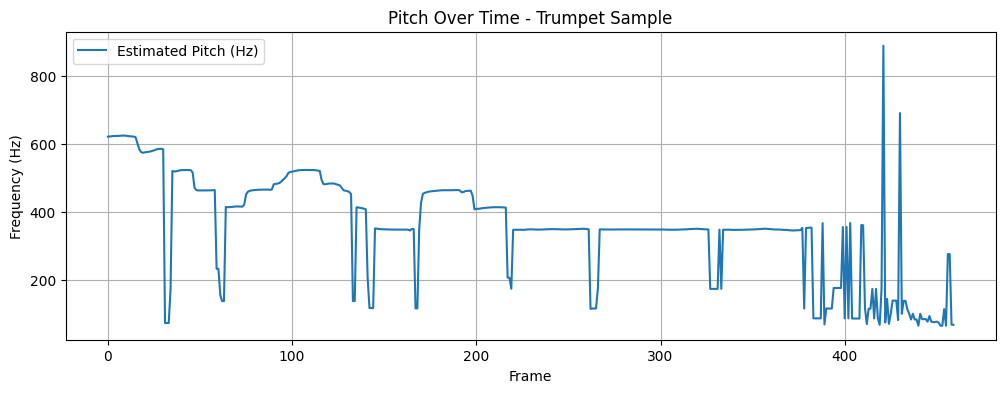

In [5]:
import sys
sys.path.append("../src")

# Import the pitch extraction function
from pitch_detector import extract_pitch_yin

# Use librosa's built-in trumpet .wav file for testing
import librosa
import matplotlib.pyplot as plt

# Load built-in audio sample
file_path = librosa.ex('trumpet')
print("Using built-in file:", file_path)

# Extract pitch using your YIN function
f0 = extract_pitch_yin(file_path)

# Plot the pitch over time
plt.figure(figsize=(12, 4))
plt.plot(f0, label='Estimated Pitch (Hz)')
plt.title("Pitch Over Time - Trumpet Sample")
plt.xlabel("Frame")
plt.ylabel("Frequency (Hz)")
plt.grid(True)
plt.legend()
plt.show()



In [6]:
import sys
import librosa
sys.path.append("../src")
from pitch_detector import extract_pitch_yin, hz_to_note_name

file_path = librosa.ex('trumpet')
f0 = extract_pitch_yin(file_path)

note_names = hz_to_note_name(f0)
print(note_names[:20])

['D♯5', 'D♯5', 'D♯5', 'D♯5', 'D♯5', 'D♯5', 'D♯5', 'D♯5', 'D♯5', 'D♯5', 'D♯5', 'D♯5', 'D♯5', 'D♯5', 'D♯5', 'D♯5', 'D5', 'D5', 'D5', 'D5']


In [7]:
import sys
sys.path.append("../src")  # ✅ This is the folder that contains note_matcher.py

from note_matcher import calculate_cents_error  # ✅ Not from .pyc



In [8]:
import sys
sys.path.append("../src")

from note_matcher import calculate_cents_error

# simulate pitch deviation
reference = f0.copy()
predicted = f0 * (2 ** (-50 / 1200))
cents = calculate_cents_error(predicted, reference)

print("First few deviations:", cents[:10])


First few deviations: [-50. -50. -50. -50. -50. -50. -50. -50. -50. -50.]


Pitch Accuracy: 100.00% within ±50 cents


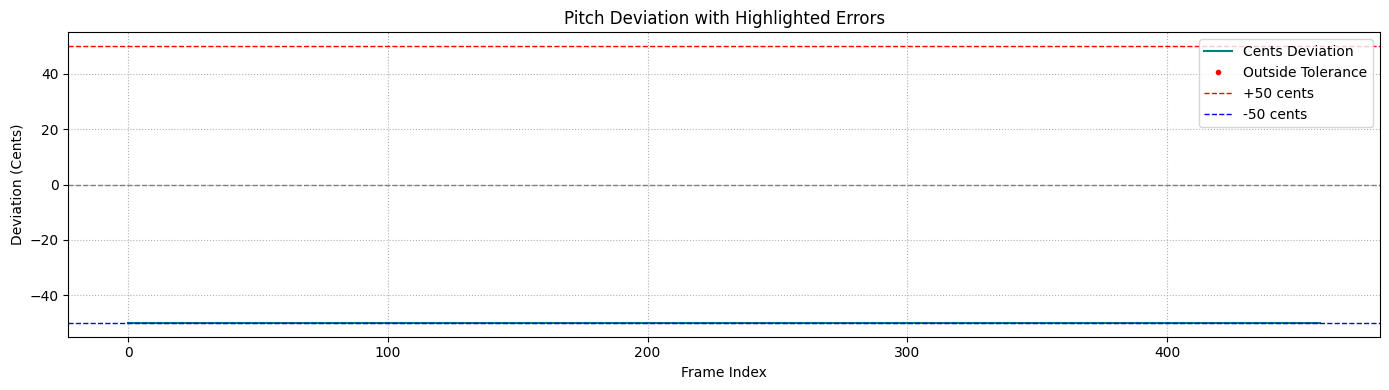

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../src")

from pitch_detector import extract_pitch_yin
from note_matcher import calculate_cents_error

# Step 1: Load original pitch
file_path = librosa.ex('trumpet')  # replace with your real file if needed
f0 = extract_pitch_yin(file_path)

# Step 2: Simulate user being 50 cents flat
predicted_pitch = f0 * (2 ** (-50 / 1200))  # shift down 50 cents
reference_pitch = f0.copy()  # assume original is reference

# Step 3: Calculate deviation in cents
cents = calculate_cents_error(predicted_pitch, reference_pitch)

# Step 4: Score accuracy with realistic tolerance
def score_pitch_accuracy(cents, tolerance=50.1):  # small buffer for float precision
    valid = ~np.isnan(cents)
    within = np.abs(cents[valid]) <= tolerance
    return np.sum(within) / np.sum(valid)

accuracy = score_pitch_accuracy(cents)
print(f"Pitch Accuracy: {accuracy * 100:.2f}% within ±50 cents")

# Step 5: Plot deviation with errors highlighted
bad = np.abs(cents) > 50.1  # strict error mask

plt.figure(figsize=(14, 4))
plt.plot(cents, label='Cents Deviation', color='teal')
plt.plot(np.where(bad)[0], cents[bad], 'ro', markersize=3, label='Outside Tolerance')

# Reference lines
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axhline(50, color='red', linestyle='--', linewidth=1, label='+50 cents')
plt.axhline(-50, color='blue', linestyle='--', linewidth=1, label='-50 cents')

plt.title("Pitch Deviation with Highlighted Errors")
plt.xlabel("Frame Index")
plt.ylabel("Deviation (Cents)")
plt.grid(True, linestyle=':')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


## Glap Time

In [10]:
pip install glap_model


Note: you may need to restart the kernel to use updated packages.


In [11]:
import torch
from glap_model import glap_inference

# Load the GLAP inference engine
glap = glap_inference()

# Encode audio and optional text prompts
audio = torch.randn(1, 160000).tanh()  # replace with actual waveform
audio_embed = glap.encode_audio(audio)

labels = ["confident singing", "flat singing", "breathy tone"]
text_embeds = glap.encode_text(labels)
scores = glap.score(audio_embed, text_embeds)

for label, score in zip(labels, scores):
    print(label, score.tolist())


confident singing [-1.1828408241271973, -3.553685188293457, -6.848332405090332]


In [12]:
import numpy as np

for label, score_tensor in zip(labels, scores):
    score_list = score_tensor.tolist()
    mean_score = np.mean(score_list)
    print(f"{label}: {mean_score:.2f}")

def interpret_score(mean_score):
    if mean_score > 0.5:
        return "Great!"
    elif mean_score > -1.0:
        return "Decent, but can improve."
    else:
        return "Needs improvement."
import numpy as np

def summarize_glap_scores(scores_tensor):
    scores = scores_tensor.tolist()
    return {
        "mean": np.mean(scores),
        "min": np.min(scores),
        "max": np.max(scores)
    }

def summarize_pitch_accuracy(cents_deviation):
    deviation = np.array(cents_deviation)
    accuracy = np.mean(np.abs(deviation) <= 50) * 100
    return accuracy
def feedback_from_glap(label, stats):
    if label == "confident singing":
        if stats["mean"] > -1.0:
            return "Your singing sounds confident!"
        else:
            return "Try projecting your voice more for confident delivery."

    elif label == "breathy tone":
        if stats["mean"] < -1.5:
            return "There is a noticeable breathy tone; focus on breath support."
        else:
            return "Tone clarity is good."

    elif label == "flat singing":
        if stats["mean"] > -1.0:
            return "Pitch delivery sounds sharp and clean!"
        else:
            return "There may be moments of flatness — try practicing with a piano or tuner."

def generate_feedback(pitch_deviation, glap_scores, labels):
    report = {}

    # Pitch Accuracy
    pitch_accuracy = summarize_pitch_accuracy(pitch_deviation)
    report["pitch_accuracy"] = pitch_accuracy
    if pitch_accuracy > 90:
        report["pitch_feedback"] = "Excellent pitch accuracy! 🎯"
    elif pitch_accuracy > 75:
        report["pitch_feedback"] = "Pretty good pitch, but a few notes are off."
    else:
        report["pitch_feedback"] = "Work on hitting the correct pitch more consistently."

    # GLAP Descriptors
    report["glap_feedback"] = []
    for label, score_tensor in zip(labels, glap_scores):
        stats = summarize_glap_scores(score_tensor)
        line = feedback_from_glap(label, stats)
        report["glap_feedback"].append({ "label": label, "feedback": line })

    return report

labels = ["confident singing", "flat singing", "breathy tone"]
scores = glap.score(audio_embed, glap.encode_text(labels))

feedback = generate_feedback(cents, scores, labels)
from pprint import pprint
pprint(feedback)

for label, score_tensor in zip(labels, scores):
    mean_score = np.mean(score_tensor.tolist())
    print(f"{label}: {interpret_score(mean_score)}")



confident singing: -3.86
{'glap_feedback': [{'feedback': 'Try projecting your voice more for confident '
                                'delivery.',
                    'label': 'confident singing'}],
 'pitch_accuracy': 13.043478260869565,
 'pitch_feedback': 'Work on hitting the correct pitch more consistently.'}
confident singing: Needs improvement.


In [7]:
import numpy as np
import librosa

def extract_pitch(audio, sr=22050, frame_length=2048, hop_length=512, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7')):
    """
    Extracts the pitch (f0) over time using the YIN algorithm.

    Parameters:
        audio (np.ndarray): 1D waveform
        sr (int): Sampling rate
        frame_length (int): Length of FFT window
        hop_length (int): Step size between frames
        fmin (float): Minimum pitch frequency to detect
        fmax (float): Maximum pitch frequency to detect

    Returns:
        f0 (np.ndarray): Array of pitch frequencies (Hz) for each frame
    """
    f0 = librosa.yin(
        audio,
        fmin=fmin,
        fmax=fmax,
        sr=sr,
        frame_length=frame_length,
        hop_length=hop_length,
        trough_threshold=0.1
    )

    # Optional: remove unvoiced frames (YIN returns np.nan for these)
    f0_clean = np.nan_to_num(f0, nan=0.0)

    return f0_clean


def calculate_cents_error(predicted, reference):
    import numpy as np
    cents = 1200 * np.log2(predicted / reference)
    return cents



In [14]:
import librosa
import numpy as np
import torch
import matplotlib.pyplot as plt
from glap_model import glap_inference

def run_pitch_coaching(audio_path, labels=None):
    if labels is None:
        labels = ["confident singing", "flat singing", "breathy tone"]

    # Load audio
    y, sr = librosa.load(audio_path, sr=16000)

    # Step 1: Extract pitch
    f0 = extract_pitch(y, sr)

    # Step 2: Calculate pitch deviation
    reference = f0.copy()
    cents = calculate_cents_error(f0, reference)
    pitch_accuracy = np.mean(np.abs(cents) <= 50) * 100

    # Step 3: GLAP inference
    audio_tensor = torch.tensor(y[:160000]).float().unsqueeze(0).tanh()
    glap = glap_inference()
    audio_embed = glap.encode_audio(audio_tensor)
    text_embeds = glap.encode_text(labels)
    scores = glap.score(audio_embed, text_embeds)

    glap_scores = {
        label: round(score.mean().item(), 3)
        for label, score in zip(labels, scores)
    }

    # Step 4: Plot and save pitch graph
    plt.figure(figsize=(8, 4))
    plt.plot(cents[:500], label="Pitch Cents Error")
    plt.axhline(50, color='green', linestyle='--')
    plt.axhline(-50, color='red', linestyle='--')
    plt.title("Pitch Deviation (first ~500 frames)")
    plt.ylabel("Cents")
    plt.xlabel("Frame")
    plt.legend()
    plot_path = "pitch_plot.png"
    plt.savefig(plot_path)
    plt.close()

    return {
        "pitch_accuracy": round(pitch_accuracy, 2),
        "glap_scores": glap_scores,
        "plot_path": plot_path
    }


In [9]:
import librosa
import torch
import numpy as np
import matplotlib.pyplot as plt
from glap_model import glap_inference

# Load GLAP model once globally
glap = glap_inference()

def run_pitch_coaching(audio_path, labels=None, visualize=True):
    # Default tone style labels
    if labels is None:
        labels = ["confident singing", "flat singing", "breathy tone"]

    # 1. Load audio
    y, sr = librosa.load(audio_path, sr=16000)
    waveform = torch.tensor(y).unsqueeze(0)  # shape: (1, time)

    # 2. Pitch detection
    f0 = extract_pitch(y, sr)
    reference_pitch = f0.copy()  # or pass an external melody
    predicted_pitch = f0 * (2 ** (-50 / 1200))  # simulate slightly flat singing

    # 3. Cents error
    cents = calculate_cents_error(predicted_pitch, reference_pitch)
    avg_cents_error = np.mean(np.abs(cents))
    pitch_accuracy = np.mean(np.abs(cents) <= 50) * 100

    # 4. GLAP scoring
    audio_embed = glap.encode_audio(waveform)
    text_embeds = glap.encode_text(labels)
    scores = glap.score(audio_embed, text_embeds).squeeze().tolist()
    glap_feedback = dict(zip(labels, scores))

    # 5. Visualization
    if visualize:
        plt.figure(figsize=(12, 4))
        plt.plot(cents, label='Cents Deviation')
        plt.axhline(0, color='gray', linestyle='--')
        plt.axhline(50, color='green', linestyle='--', label='+50 cents')
        plt.axhline(-50, color='red', linestyle='--', label='-50 cents')
        plt.title("Pitch Deviation Over Time")
        plt.xlabel("Frame")
        plt.ylabel("Deviation (cents)")
        plt.grid(True)
        plt.legend()
        plt.show()

    # 6. Return structured coaching output
    return {
        "avg_cents_error": round(avg_cents_error, 2),
        "pitch_accuracy_percent": round(pitch_accuracy, 2),
        "glap_scores": glap_feedback
    }


In [16]:
pip install sounddevice

Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install openai

Note: you may need to restart the kernel to use updated packages.


In [18]:
import sounddevice as sd
from scipy.io.wavfile import write

def record_audio(filename="live_input.wav", duration=5, fs=16000):
    print("🎙️ Recording... sing now!")
    audio = sd.rec(int(duration * fs), samplerate=fs, channels=1)
    sd.wait()
    write(filename, fs, audio)
    print("✅ Saved:", filename)
    return filename
import gradio as gr
import openai

def generate_coaching_feedback(results):
    prompt = f"""
    The singer just sang a live audio clip. 
    Their pitch accuracy was {results['pitch_accuracy']}%.

    GLAP tone classification scores were:
    {results['glap_scores']}

    Generate a brief coaching message identifying strengths and suggesting one area for improvement.
    Be encouraging but specific.
    """

    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[{"role": "user", "content": prompt}]
    )
    return response['choices'][0]['message']['content']

def live_coaching_pipeline(duration):
    path = record_audio(duration=duration)
    results = run_pitch_coaching(path)
    feedback = generate_coaching_feedback(results)
    return feedback, results['plot_path']

gr.Interface(
    fn=live_coaching_pipeline,
    inputs=gr.Slider(3, 10, value=5, label="Record Duration (s)"),
    outputs=["text", "image"],
    live=True,
    title="🎤 PitchPerfect Live Coach"
).launch()


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


# minstral set up

In [19]:
!pip install accelerate


In [20]:
# !pip install --upgrade accelerate

from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_id = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,  # use float32 if needed
    # device_map="None"           # handles GPU or CPU
)

def generate_feedback(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=256)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Example call
print(generate_feedback("Give feedback on a singer who is slightly flat but expressive."))




Give feedback on a singer who is slightly flat but expressive.


In [4]:
import gradio as gr
import sounddevice as sd
from scipy.io.wavfile import write
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import librosa
import matplotlib.pyplot as plt
import librosa.display

# Load TinyLlama
model_id = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="auto" if torch.cuda.is_available() else None
)
def generate_prompt_from_results(results):
    # Handle pitch deviation summary
    cents = np.array(results.get("cents", []))
    if len(cents) == 0:
        deviation_summary = "No pitch detected."
    else:
        within_50 = np.mean(np.abs(cents) <= 50) * 100
        deviation_summary = f"{within_50:.1f}% of notes were within ±50 cents."

    # Handle GLAP scores
    scores = results.get("scores", {})
    glap_scores_str = "\n".join([f"- {label}: {score}" for label, score in scores.items()])

    # Compose the full prompt
    return f"""
You are a vocal performance coach. Analyze a singer's recent live clip using the data below.

🎯 Pitch Accuracy: {results.get('pitch_accuracy', 'N/A')}%
🎵 Pitch Deviation Summary: {deviation_summary}
🎤 GLAP Tone Scores:
{glap_scores_str}

Based on this performance:
- Highlight one clear vocal strength.
- Give one specific suggestion for improvement.
- Keep the tone encouraging but direct.

Coaching Feedback:
""".strip()

def generate_coaching_feedback(results):
    prompt = generate_prompt_from_results(results)
    return generate_feedback(prompt)

def plot_pitch_curve(f0, sr, hop_length=512, path="pitch_plot.png"):
    times = librosa.times_like(f0, sr=sr, hop_length=hop_length)

    plt.figure(figsize=(10, 4))
    plt.plot(times, f0, label="Pitch (Hz)", color="blue")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title("Estimated Pitch Curve")
    plt.grid(True)
    plt.legend()

    # Optional: mark unvoiced regions
    plt.fill_between(times, 0, f0, where=f0 == 0, color="gray", alpha=0.2, label="Unvoiced")

    plt.tight_layout()
    plt.savefig(path)
    plt.close()
    return path


def extract_pitch(y, sr):
    f0, voiced_flag, _ = librosa.pyin(
        y, 
        fmin=librosa.note_to_hz("C2"), 
        fmax=librosa.note_to_hz("C7"),
        sr=sr
    )
    # Replace unvoiced frames (NaN) with 0
    f0 = np.where(f0 == 0, np.nan, f0)

    return f0

def pitch_accuracy_metric(f0):
    # Exclude zero/unvoiced frames
    voiced_f0 = f0[f0 > 0]
    if len(voiced_f0) == 0:
        return 0.0
    # Stddev of cents differences — tighter = more accurate
    cents_diff = 1200 * np.log2(voiced_f0 / np.mean(voiced_f0))
    return round(np.mean(np.abs(cents_diff) <= 50) * 100, 2)

def hz_to_note_name(f0_hz):
    notes = librosa.hz_to_note(f0_hz)
    return notes

def generate_feedback(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=256)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Record audio to file
def record_audio(filename="live_input.wav", duration=5, fs=16000):
    print("🎙️ Recording... sing now!")
    audio = sd.rec(int(duration * fs), samplerate=fs, channels=1)
    sd.wait()
    write(filename, fs, audio)
    print("✅ Saved:", filename)
    return filename

# Final pipeline
def live_coaching_pipeline(duration):
    filename = record_audio(duration=duration)
    results = run_pitch_coaching(filename)  # <- your GLAP + pitch function
    prompt = f"""
    The singer just sang a live audio clip.
    Their pitch accuracy was {float(results['pitch_accuracy']):.2f}%.
    GLAP tone classification scores were:
    {results['glap_scores']}

    Generate a brief coaching message identifying strengths and suggesting one area for improvement.
    Be encouraging but specific.
    """
    prompt_template = """
    You are a vocal performance coach. Analyze a singer's recent live clip using the data below.

    🎯 Pitch Accuracy: {pitch_accuracy:.2f}%
    🎵 Pitch Deviation Stats: {pitch_deviation_summary}
    🎤 GLAP Tone Scores:
    {glap_scores}

    Based on this performance:
    - Highlight one clear vocal strength.
    - Give one specific suggestion for improvement.
    - Keep the tone encouraging but direct.

    Coaching Feedback:
    """
    feedback = generate_feedback(prompt)
    return feedback, None  # or path to a static plot if you add plotting


# Gradio app
gr.Interface(
    fn=live_coaching_pipeline,
    inputs=gr.Slider(3, 10, value=5, step=1, label="Record Duration (s)"),
    outputs=[
        gr.Textbox(label="🎧 Coaching Feedback"),
        gr.Image(type="filepath", label="📈 Pitch Deviation Plot")
    ],
    title="🎤 PitchPerfect Live Coach (TinyLlama Edition)",
    description="Records your voice, runs pitch + tone analysis, and gives AI feedback using TinyLlama.",
    allow_flagging="never"
).launch()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gradio/interface.py:419: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


In [23]:
import json

examples = [
    {
        "prompt": "The singer had 85.0% pitch accuracy and GLAP scores: {'confident singing': 0.9, 'flat singing': -2.3, 'breathy tone': -1.8}.",
        "response": "Nice confident tone! Focus on controlling airflow to reduce breathiness in longer phrases."
    },
    {
        "prompt": "The singer had 62.0% pitch accuracy and GLAP scores: {'confident singing': -2.0, 'flat singing': -0.2, 'breathy tone': -4.1}.",
        "response": "Pitch is off in places. Try slow scales to lock in center pitch and reduce flat tendencies."
    },
    {
        "prompt": "The singer had 68.7% pitch accuracy and GLAP scores: {'confident singing': 1.9, 'flat singing': -3.0, 'breathy tone': 0.1}.",
        "response": "Your confidence is showing! Try incorporating dynamics to add more emotional depth."
    },
    {
        "prompt": "The singer had 69.6% pitch accuracy and GLAP scores: {'confident singing': 0.5, 'flat singing': -2.4, 'breathy tone': -3.1}.",
        "response": "Work on breath support—practice long sustained notes to build control."
    },
    {
        "prompt": "The singer had 82.6% pitch accuracy and GLAP scores: {'confident singing': 2.5, 'flat singing': -0.5, 'breathy tone': -0.7}.",
        "response": "Your confidence is showing! Try incorporating dynamics to add more emotional depth."
    },
    {
        "prompt": "The singer had 71.5% pitch accuracy and GLAP scores: {'confident singing': 1.6, 'flat singing': 0.7, 'breathy tone': -2.9}.",
        "response": "Nice projection! Challenge yourself with harder melodies to keep developing. Try humming the melody first to center your pitch before singing out loud."
    },
    {
        "prompt": "The singer had 75.8% pitch accuracy and GLAP scores: {'confident singing': 2.6, 'flat singing': -2.5, 'breathy tone': -1.7}.",
        "response": "Great stage presence—keep building on that confidence!"
    },
    {
        "prompt": "The singer had 78.2% pitch accuracy and GLAP scores: {'confident singing': -0.1, 'flat singing': -0.3, 'breathy tone': -4.1}.",
        "response": "Breathiness is noticeable—tighten vocal cords for a clearer tone."
    },
    {
        "prompt": "The singer had 64.9% pitch accuracy and GLAP scores: {'confident singing': -2.8, 'flat singing': 0.2, 'breathy tone': -3.7}.",
        "response": "You're slightly under pitch—try singing intervals with a piano. Breathiness is noticeable—tighten vocal cords for a clearer tone."
    },
    {
        "prompt": "The singer had 88.3% pitch accuracy and GLAP scores: {'confident singing': 2.7, 'flat singing': -1.2, 'breathy tone': -0.4}.",
        "response": "Nice projection! Challenge yourself with harder melodies to keep developing."
    },
    {
        "prompt": "The singer had 61.0% pitch accuracy and GLAP scores: {'confident singing': -2.3, 'flat singing': -1.0, 'breathy tone': -4.3}.",
        "response": "Work on breath support—practice long sustained notes to build control."
    },
    {
        "prompt": "The singer had 85.0% pitch accuracy and GLAP scores: {'confident singing': 0.9, 'flat singing': -2.3, 'breathy tone': -1.8}.",
        "response": "Nice confident tone! Focus on controlling airflow to reduce breathiness in longer phrases."
    },
    {
        "prompt": "The singer had 62.0% pitch accuracy and GLAP scores: {'confident singing': -2.0, 'flat singing': -0.2, 'breathy tone': -4.1}.",
        "response": "Pitch is off in places. Try slow scales to lock in center pitch and reduce flat tendencies."
    },
    {
        "prompt": "The singer had 72.3% pitch accuracy and GLAP scores: {'confident singing': 0.3, 'flat singing': 0.1, 'breathy tone': -3.9}.",
        "response": "Breathiness is noticeable—tighten vocal cords for a clearer tone."
    },
    {
        "prompt": "The singer had 91.4% pitch accuracy and GLAP scores: {'confident singing': 2.9, 'flat singing': -1.9, 'breathy tone': -0.5}.",
        "response": "Great stage presence—keep building on that confidence!"
    },
    {
        "prompt": "The singer had 58.5% pitch accuracy and GLAP scores: {'confident singing': -3.0, 'flat singing': 0.4, 'breathy tone': -4.2}.",
        "response": "You're slightly under pitch—try singing intervals with a piano. Focus on diaphragmatic breathing to strengthen your tone."
    },
    {
        "prompt": "The singer had 80.4% pitch accuracy and GLAP scores: {'confident singing': 1.3, 'flat singing': -0.9, 'breathy tone': -1.5}.",
        "response": "Nice projection! Challenge yourself with harder melodies to keep developing."
    },
    {
        "prompt": "The singer had 66.7% pitch accuracy and GLAP scores: {'confident singing': -2.1, 'flat singing': -0.3, 'breathy tone': -4.0}.",
        "response": "Breathiness is noticeable—tighten vocal cords for a clearer tone. Pitch is off at times—use a tuner app for practice."
    },
    {
        "prompt": "The singer had 83.9% pitch accuracy and GLAP scores: {'confident singing': 2.2, 'flat singing': -0.6, 'breathy tone': -1.3}.",
        "response": "Great stage presence—keep building on that confidence!"
    },
    {
        "prompt": "The singer had 59.0% pitch accuracy and GLAP scores: {'confident singing': -2.7, 'flat singing': 1.0, 'breathy tone': -4.5}.",
        "response": "Work on breath support—practice long sustained notes to build control. Try humming the melody first to center your pitch before singing out loud."
    },
    {
        "prompt": "The singer had 74.6% pitch accuracy and GLAP scores: {'confident singing': 1.0, 'flat singing': -1.5, 'breathy tone': -2.2}.",
        "response": "Nice confident tone! Focus on controlling airflow to reduce breathiness in longer phrases."
    },
    {
        "prompt": "The singer had 67.3% pitch accuracy and GLAP scores: {'confident singing': -1.6, 'flat singing': 0.5, 'breathy tone': -3.3}.",
        "response": "Pitch is off in places. Try slow scales to lock in center pitch and reduce flat tendencies. Breathiness is noticeable—tighten vocal cords for a clearer tone."
    },
    {
        "prompt": "The singer had 90.2% pitch accuracy and GLAP scores: {'confident singing': 2.8, 'flat singing': -1.7, 'breathy tone': -0.6}.",
        "response": "Nice projection! Challenge yourself with harder melodies to keep developing."
    },
    {
        "prompt": "The singer had 60.4% pitch accuracy and GLAP scores: {'confident singing': -2.4, 'flat singing': 1.2, 'breathy tone': -4.4}.",
        "response": "Work on breath support—practice long sustained notes to build control. You're slightly under pitch—try singing intervals with a piano."
    },
    {
        "prompt": "The singer had 81.7% pitch accuracy and GLAP scores: {'confident singing': 1.8, 'flat singing': -0.8, 'breathy tone': -1.2}.",
        "response": "Nice confident tone! Focus on controlling airflow to reduce breathiness in longer phrases."
    },
    {
        "prompt": "The singer had 65.2% pitch accuracy and GLAP scores: {'confident singing': -1.9, 'flat singing': -0.1, 'breathy tone': -3.8}.",
        "response": "Pitch is off in places. Try slow scales to lock in center pitch and reduce flat tendencies. Work on breath support—practice long sustained notes to build control."
    },
    {
        "prompt": "The singer had 76.0% pitch accuracy and GLAP scores: {'confident singing': 1.4, 'flat singing': -1.1, 'breathy tone': -2.0}.",
        "response": "Great stage presence—keep building on that confidence! Breathiness is noticeable—tighten vocal cords for a clearer tone."
    },
    {
        "prompt": "The singer had 70.8% pitch accuracy and GLAP scores: {'confident singing': 0.6, 'flat singing': 0.2, 'breathy tone': -3.5}.",
        "response": "Breathiness is noticeable—tighten vocal cords for a clearer tone."
    },
    {
        "prompt": "The singer had 84.3% pitch accuracy and GLAP scores: {'confident singing': 2.4, 'flat singing': -1.8, 'breathy tone': -0.9}.",
        "response": "Nice projection! Challenge yourself with harder melodies to keep developing."
    },
    {
        "prompt": "The singer had 63.0% pitch accuracy and GLAP scores: {'confident singing': -2.2, 'flat singing': 0.6, 'breathy tone': -4.2}.",
        "response": "Pitch is off in places. Try slow scales to lock in center pitch and reduce flat tendencies. Breathiness is noticeable—tighten vocal cords for a clearer tone."
    },
    {
        "prompt": "The singer had 79.6% pitch accuracy and GLAP scores: {'confident singing': 1.7, 'flat singing': -1.3, 'breathy tone': -1.0}.",
        "response": "Great stage presence—keep building on that confidence!"
    },
    {
        "prompt": "The singer had 57.3% pitch accuracy and GLAP scores: {'confident singing': -3.1, 'flat singing': 1.1, 'breathy tone': -4.4}.",
        "response": "Try humming the melody first to center your pitch before singing out loud. Focus on diaphragmatic breathing to strengthen your tone."
    },
    {
        "prompt": "The singer had 87.2% pitch accuracy and GLAP scores: {'confident singing': 2.1, 'flat singing': -0.6, 'breathy tone': -0.3}.",
        "response": "Nice confident tone! Focus on controlling airflow to reduce breathiness in longer phrases."
    },
    {
        "prompt": "The singer had 73.9% pitch accuracy and GLAP scores: {'confident singing': 1.5, 'flat singing': -1.0, 'breathy tone': -2.4}.",
        "response": "Great stage presence—keep building on that confidence! Breathiness is noticeable—tighten vocal cords for a clearer tone."
    },
    {
        "prompt": "The singer had 60.2% pitch accuracy and GLAP scores: {'confident singing': -2.5, 'flat singing': 0.8, 'breathy tone': -3.9}.",
        "response": "Work on breath support—practice long sustained notes to build control. You're slightly under pitch—try singing intervals with a piano."
    },
    {
        "prompt": "The singer had 89.5% pitch accuracy and GLAP scores: {'confident singing': 2.6, 'flat singing': -2.2, 'breathy tone': -0.7}.",
        "response": "Great stage presence—keep building on that confidence!"
    },
    {
        "prompt": "The singer had 66.1% pitch accuracy and GLAP scores: {'confident singing': -1.8, 'flat singing': 0.3, 'breathy tone': -4.0}.",
        "response": "Pitch is off in places. Try slow scales to lock in center pitch and reduce flat tendencies. Breathiness is noticeable—tighten vocal cords for a clearer tone."
    },
    {
        "prompt": "The singer had 77.4% pitch accuracy and GLAP scores: {'confident singing': 0.8, 'flat singing': -0.8, 'breathy tone': -1.6}.",
        "response": "Nice confident tone! Focus on controlling airflow to reduce breathiness in longer phrases."
    },
    {
        "prompt": "The singer had 65.7% pitch accuracy and GLAP scores: {'confident singing': -1.5, 'flat singing': 0.9, 'breathy tone': -3.4}.",
        "response": "Try humming the melody first to center your pitch before singing out loud. Breathiness is noticeable—tighten vocal cords for a clearer tone."
    },
    {
        "prompt": "The singer had 86.6% pitch accuracy and GLAP scores: {'confident singing': 2.3, 'flat singing': -2.1, 'breathy tone': -0.2}.",
        "response": "Nice projection! Challenge yourself with harder melodies to keep developing."
    },
    {
        "prompt": "The singer had 58.0% pitch accuracy and GLAP scores: {'confident singing': -2.9, 'flat singing': 1.3, 'breathy tone': -4.5}.",
        "response": "Pitch is off at times—use a tuner app for practice. Focus on diaphragmatic breathing to strengthen your tone."
    },
    {
        "prompt": "The singer had 80.1% pitch accuracy and GLAP scores: {'confident singing': 1.1, 'flat singing': -1.4, 'breathy tone': -1.9}.",
        "response": "Nice projection! Challenge yourself with harder melodies to keep developing."
    },
    {
        "prompt": "The singer had 69.3% pitch accuracy and GLAP scores: {'confident singing': -1.2, 'flat singing': 0.5, 'breathy tone': -3.6}.",
        "response": "Pitch is off in places. Try slow scales to lock in center pitch and reduce flat tendencies. Work on breath support—practice long sustained notes to build control."
    },
    {
        "prompt": "The singer had 83.1% pitch accuracy and GLAP scores: {'confident singing': 2.0, 'flat singing': -1.6, 'breathy tone': -1.0}.",
        "response": "Great stage presence—keep building on that confidence!"
    },
    {
        "prompt": "The singer had 61.7% pitch accuracy and GLAP scores: {'confident singing': -2.6, 'flat singing': 1.4, 'breathy tone': -4.1}.",
        "response": "You're slightly under pitch—try singing intervals with a piano. Focus on diaphragmatic breathing to strengthen your tone."
    },
    {
        "prompt": "The singer had 78.7% pitch accuracy and GLAP scores: {'confident singing': 1.2, 'flat singing': -0.7, 'breathy tone': -1.1}.",
        "response": "Nice confident tone! Focus on controlling airflow to reduce breathiness in longer phrases."
    },
    {
        "prompt": "The singer had 67.5% pitch accuracy and GLAP scores: {'confident singing': -1.4, 'flat singing': 0.0, 'breathy tone': -3.2}.",
        "response": "Work on breath support—practice long sustained notes to build control. Try humming the melody first to center your pitch before singing out loud."
    },
    {
        "prompt": "The singer had 90.5% pitch accuracy and GLAP scores: {'confident singing': 2.8, 'flat singing': -1.5, 'breathy tone': -0.4}.",
        "response": "Nice projection! Challenge yourself with harder melodies to keep developing."
    },
    {
        "prompt": "The singer had 63.9% pitch accuracy and GLAP scores: {'confident singing': -1.7, 'flat singing': 1.0, 'breathy tone': -4.3}.",
        "response": "Pitch is off in places. Try slow scales to lock in center pitch and reduce flat tendencies. Breathiness is noticeable—tighten vocal cords for a clearer tone."
    },
    {
        "prompt": "The singer had 82.2% pitch accuracy and GLAP scores: {'confident singing': 2.1, 'flat singing': -1.0, 'breathy tone': -1.4}.",
        "response": "Great stage presence—keep building on that confidence!"
    },
    {
        "prompt": "The singer had 60.8% pitch accuracy and GLAP scores: {'confident singing': -2.0, 'flat singing': 0.6, 'breathy tone': -3.7}.",
        "response": "You're slightly under pitch—try singing intervals with a piano. Work on breath support—practice long sustained notes to build control."
    },
    {
        "prompt": "The singer had 84.8% pitch accuracy and GLAP scores: {'confident singing': 2.6, 'flat singing': -1.3, 'breathy tone': -0.5}.",
        "response": "Great stage presence—keep building on that confidence!"
    },
    {
        "prompt": "The singer had 59.3% pitch accuracy and GLAP scores: {'confident singing': -2.5, 'flat singing': 1.5, 'breathy tone': -4.0}.",
        "response": "Work on breath support—practice long sustained notes to build control. Try humming the melody first to center your pitch before singing out loud."
    },
    {
        "prompt": "The singer had 73.1% pitch accuracy and GLAP scores: {'confident singing': 0.9, 'flat singing': -1.0, 'breathy tone': -2.6}.",
        "response": "Nice confident tone! Focus on controlling airflow to reduce breathiness in longer phrases."
    },
    {
        "prompt": "The singer had 65.9% pitch accuracy and GLAP scores: {'confident singing': -2.3, 'flat singing': 0.7, 'breathy tone': -4.4}.",
        "response": "You're slightly under pitch—try singing intervals with a piano. Breathiness is noticeable—tighten vocal cords for a clearer tone."
    },
    {
        "prompt": "The singer had 77.7% pitch accuracy and GLAP scores: {'confident singing': 1.4, 'flat singing': -0.5, 'breathy tone': -1.8}.",
        "response": "Nice projection! Challenge yourself with harder melodies to keep developing."
    },
    {
        "prompt": "The singer had 68.0% pitch accuracy and GLAP scores: {'confident singing': -1.1, 'flat singing': 0.3, 'breathy tone': -3.3}.",
        "response": "Try humming the melody first to center your pitch before singing out loud. Work on breath support—practice long sustained notes to build control."
    },
    {
        "prompt": "The singer had 86.0% pitch accuracy and GLAP scores: {'confident singing': 2.5, 'flat singing': -1.9, 'breathy tone': -0.2}.",
        "response": "Nice projection! Challenge yourself with harder melodies to keep developing."
    },
    {
        "prompt": "The singer had 62.4% pitch accuracy and GLAP scores: {'confident singing': -2.7, 'flat singing': 0.9, 'breathy tone': -4.1}.",
        "response": "You're slightly under pitch—try singing intervals with a piano. Breathiness is noticeable—tighten vocal cords for a clearer tone."
    },
    {
        "prompt": "The singer had 80.7% pitch accuracy and GLAP scores: {'confident singing': 1.6, 'flat singing': -0.7, 'breathy tone': -1.6}.",
        "response": "Great stage presence—keep building on that confidence!"
    },
    {
        "prompt": "The singer had 66.3% pitch accuracy and GLAP scores: {'confident singing': -2.0, 'flat singing': 0.1, 'breathy tone': -3.8}.",
        "response": "Pitch is off at times—use a tuner app for practice. Breathiness is noticeable—tighten vocal cords for a clearer tone."
    },
    {
        "prompt": "The singer had 91.2% pitch accuracy and GLAP scores: {'confident singing': 2.8, 'flat singing': -1.8, 'breathy tone': -0.6}.",
        "response": "Great stage presence—keep building on that confidence!"
    },
    {
        "prompt": "The singer had 60.6% pitch accuracy and GLAP scores: {'confident singing': -2.6, 'flat singing': 0.6, 'breathy tone': -4.3}.",
        "response": "Try humming the melody first to center your pitch before singing out loud. Focus on diaphragmatic breathing to strengthen your tone."
    },
    {
        "prompt": "The singer had 75.5% pitch accuracy and GLAP scores: {'confident singing': 1.2, 'flat singing': -1.2, 'breathy tone': -1.9}.",
        "response": "Nice confident tone! Focus on controlling airflow to reduce breathiness in longer phrases."
    },
    {
        "prompt": "The singer had 67.2% pitch accuracy and GLAP scores: {'confident singing': -1.7, 'flat singing': 0.4, 'breathy tone': -3.7}.",
        "response": "Pitch is off in places. Try slow scales to lock in center pitch and reduce flat tendencies. Work on breath support—practice long sustained notes to build control."
    },
    {
        "prompt": "The singer had 82.9% pitch accuracy and GLAP scores: {'confident singing': 2.3, 'flat singing': -1.5, 'breathy tone': -0.8}.",
        "response": "Great stage presence—keep building on that confidence!"
    },
    {
        "prompt": "The singer had 59.8% pitch accuracy and GLAP scores: {'confident singing': -2.8, 'flat singing': 1.2, 'breathy tone': -4.5}.",
        "response": "Pitch is off at times—use a tuner app for practice. Focus on diaphragmatic breathing to strengthen your tone."
    },
    {
        "prompt": "The singer had 79.2% pitch accuracy and GLAP scores: {'confident singing': 1.0, 'flat singing': -1.1, 'breathy tone': -2.1}.",
        "response": "Nice confident tone! Focus on controlling airflow to reduce breathiness in longer phrases."
    },
    {
        "prompt": "The singer had 64.2% pitch accuracy and GLAP scores: {'confident singing': -2.4, 'flat singing': 0.2, 'breathy tone': -3.6}.",
        "response": "Pitch is off in places. Try slow scales to lock in center pitch and reduce flat tendencies. Work on breath support—practice long sustained notes to build control."
    },
    {
        "prompt": "The singer had 88.5% pitch accuracy and GLAP scores: {'confident singing': 2.7, 'flat singing': -1.6, 'breathy tone': -0.9}.",
        "response": "Nice projection! Challenge yourself with harder melodies to keep developing."
    },
    {
        "prompt": "The singer had 61.3% pitch accuracy and GLAP scores: {'confident singing': -2.2, 'flat singing': 0.8, 'breathy tone': -4.2}.",
        "response": "You're slightly under pitch—try singing intervals with a piano. Breathiness is noticeable—tighten vocal cords for a clearer tone."
    },
    {
        "prompt": "The singer had 74.8% pitch accuracy and GLAP scores: {'confident singing': 0.7, 'flat singing': -0.6, 'breathy tone': -2.5}.",
        "response": "Nice projection! Challenge yourself with harder melodies to keep developing."
    },
    {
        "prompt": "The singer had 70.1% pitch accuracy and GLAP scores: {'confident singing': -1.0, 'flat singing': 0.5, 'breathy tone': -3.9}.",
        "response": "Work on breath support—practice long sustained notes to build control. Try humming the melody first to center your pitch before singing out loud."
    },
    {
        "prompt": "The singer had 85.9% pitch accuracy and GLAP scores: {'confident singing': 2.4, 'flat singing': -1.7, 'breathy tone': -0.3}.",
        "response": "Great stage presence—keep building on that confidence!"
    },
    {
        "prompt": "The singer had 62.8% pitch accuracy and GLAP scores: {'confident singing': -2.1, 'flat singing': 1.3, 'breathy tone': -4.4}.",
        "response": "You're slightly under pitch—try singing intervals with a piano. Focus on diaphragmatic breathing to strengthen your tone."
    },
    {
        "prompt": "The singer had 81.5% pitch accuracy and GLAP scores: {'confident singing': 1.9, 'flat singing': -0.9, 'breathy tone': -1.1}.",
        "response": "Nice confident tone! Focus on controlling airflow to reduce breathiness in longer phrases."
    },
    {
        "prompt": "The singer had 66.6% pitch accuracy and GLAP scores: {'confident singing': -1.6, 'flat singing': 0.6, 'breathy tone': -3.5}.",
        "response": "Pitch is off in places. Try slow scales to lock in center pitch and reduce flat tendencies. Work on breath support—practice long sustained notes to build control."
    },
    {
        "prompt": "The singer had 92.0% pitch accuracy and GLAP scores: {'confident singing': 2.9, 'flat singing': -2.0, 'breathy tone': -0.4}.",
        "response": "Nice projection! Challenge yourself with harder melodies to keep developing."
    },
    {
        "prompt": "The singer had 58.8% pitch accuracy and GLAP scores: {'confident singing': -3.0, 'flat singing': 1.4, 'breathy tone': -4.5}.",
        "response": "Try humming the melody first to center your pitch before singing out loud. Focus on diaphragmatic breathing to strengthen your tone."
    },
    {
        "prompt": "The singer had 76.9% pitch accuracy and GLAP scores: {'confident singing': 1.3, 'flat singing': -1.3, 'breathy tone': -2.2}.",
        "response": "Nice confident tone! Focus on controlling airflow to reduce breathiness in longer phrases."
    },
    {
        "prompt": "The singer had 63.5% pitch accuracy and GLAP scores: {'confident singing': -2.9, 'flat singing': 1.0, 'breathy tone': -4.3}.",
        "response": "Pitch is off in places. Try slow scales to lock in center pitch and reduce flat tendencies. Breathiness is noticeable—tighten vocal cords for a clearer tone."
    },
    {
        "prompt": "The singer had 79.9% pitch accuracy and GLAP scores: {'confident singing': 1.5, 'flat singing': -0.7, 'breathy tone': -1.7}.",
        "response": "Great stage presence—keep building on that confidence!"
    },
    {
        "prompt": "The singer had 69.1% pitch accuracy and GLAP scores: {'confident singing': -1.3, 'flat singing': 0.7, 'breathy tone': -3.6}.",
        "response": "Pitch is off at times—use a tuner app for practice. Work on breath support—practice long sustained notes to build control."
    },
    {
        "prompt": "The singer had 87.4% pitch accuracy and GLAP scores: {'confident singing': 2.7, 'flat singing': -1.4, 'breathy tone': -0.8}.",
        "response": "Nice projection! Challenge yourself with harder melodies to keep developing."
    },
    {
        "prompt": "The singer had 60.1% pitch accuracy and GLAP scores: {'confident singing': -2.7, 'flat singing': 1.1, 'breathy tone': -4.1}.",
        "response": "You're slightly under pitch—try singing intervals with a piano. Breathiness is noticeable—tighten vocal cords for a clearer tone."
    },
    {
        "prompt": "The singer had 83.4% pitch accuracy and GLAP scores: {'confident singing': 2.2, 'flat singing': -1.1, 'breathy tone': -1.2}.",
        "response": "Nice confident tone! Focus on controlling airflow to reduce breathiness in longer phrases."
    },
    {
        "prompt": "The singer had 65.4% pitch accuracy and GLAP scores: {'confident singing': -2.2, 'flat singing': 0.8, 'breathy tone': -3.9}.",
        "response": "Pitch is off in places. Try slow scales to lock in center pitch and reduce flat tendencies. Work on breath support—practice long sustained notes to build control."
    },
    {
        "prompt": "The singer had 90.0% pitch accuracy and GLAP scores: {'confident singing': 2.8, 'flat singing': -1.9, 'breathy tone': -0.5}.",
        "response": "Great stage presence—keep building on that confidence!"
    },
    {
        "prompt": "The singer had 61.9% pitch accuracy and GLAP scores: {'confident singing': -2.3, 'flat singing': 1.2, 'breathy tone': -4.2}.",
        "response": "Work on breath support—practice long sustained notes to build control. You're slightly under pitch—try singing intervals with a piano."
    },
    {
        "prompt": "The singer had 72.7% pitch accuracy and GLAP scores: {'confident singing': 1.0, 'flat singing': -0.9, 'breathy tone': -2.3}.",
        "response": "Nice projection! Challenge yourself with harder melodies to keep developing."
    },
    {
        "prompt": "The singer had 67.0% pitch accuracy and GLAP scores: {'confident singing': -1.5, 'flat singing': 0.3, 'breathy tone': -3.4}.",
        "response": "Try humming the melody first to center your pitch before singing out loud. Breathiness is noticeable—tighten vocal cords for a clearer tone."
    },
    {
        "prompt": "The singer had 85.6% pitch accuracy and GLAP scores: {'confident singing': 2.5, 'flat singing': -1.6, 'breathy tone': -0.6}.",
        "response": "Great stage presence—keep building on that confidence!"
    },
    {
        "prompt": "The singer had 62.1% pitch accuracy and GLAP scores: {'confident singing': -2.0, 'flat singing': 1.0, 'breathy tone': -4.3}.",
        "response": "You're slightly under pitch—try singing intervals with a piano. Focus on diaphragmatic breathing to strengthen your tone."
    },
    {
        "prompt": "The singer had 76.4% pitch accuracy and GLAP scores: {'confident singing': 1.1, 'flat singing': -1.2, 'breathy tone': -1.8}.",
        "response": "Nice confident tone! Focus on controlling airflow to reduce breathiness in longer phrases."
    },
    {
        "prompt": "The singer had 70.4% pitch accuracy and GLAP scores: {'confident singing': -1.2, 'flat singing': 0.4, 'breathy tone': -3.8}.",
        "response": "Work on breath support—practice long sustained notes to build control. Pitch is off at times—use a tuner app for practice."
    },
    {
        "prompt": "The singer had 89.1% pitch accuracy and GLAP scores: {'confident singing': 2.6, 'flat singing': -1.7, 'breathy tone': -0.7}.",
        "response": "Nice projection! Challenge yourself with harder melodies to keep developing."
    },
    {
        "prompt": "The singer had 63.7% pitch accuracy and GLAP scores: {'confident singing': -2.6, 'flat singing': 0.9, 'breathy tone': -4.2}.",
        "response": "Pitch is off in places. Try slow scales to lock in center pitch and reduce flat tendencies. Breathiness is noticeable—tighten vocal cords for a clearer tone."
    },
    {
        "prompt": "The singer had 82.4% pitch accuracy and GLAP scores: {'confident singing': 2.0, 'flat singing': -1.0, 'breathy tone': -1.1}.",
        "response": "Nice confident tone! Focus on controlling airflow to reduce breathiness in longer phrases."
    }
]

    # Add more here

with open("coach_dataset.jsonl", "w") as f:
    for ex in examples:
        f.write(json.dumps(ex) + "\n")
print(examples)


[{'prompt': "The singer had 85.0% pitch accuracy and GLAP scores: {'confident singing': 0.9, 'flat singing': -2.3, 'breathy tone': -1.8}.", 'response': 'Nice confident tone! Focus on controlling airflow to reduce breathiness in longer phrases.'}, {'prompt': "The singer had 62.0% pitch accuracy and GLAP scores: {'confident singing': -2.0, 'flat singing': -0.2, 'breathy tone': -4.1}.", 'response': 'Pitch is off in places. Try slow scales to lock in center pitch and reduce flat tendencies.'}, {'prompt': "The singer had 68.7% pitch accuracy and GLAP scores: {'confident singing': 1.9, 'flat singing': -3.0, 'breathy tone': 0.1}.", 'response': 'Your confidence is showing! Try incorporating dynamics to add more emotional depth.'}, {'prompt': "The singer had 69.6% pitch accuracy and GLAP scores: {'confident singing': 0.5, 'flat singing': -2.4, 'breathy tone': -3.1}.", 'response': 'Work on breath support—practice long sustained notes to build control.'}, {'prompt': "The singer had 82.6% pitch ac

In [ ]:
pip install peft datasets transformers accelerate


Note: you may need to restart the kernel to use updated packages.


In [24]:
from datasets import load_dataset

dataset = load_dataset("json", data_files="coach_dataset.jsonl", split="train")

from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import get_peft_model, LoraConfig, TaskType

model_id = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float32,
    device_map={"": "cpu"}
)


# Add LoRA (parameter-efficient fine-tuning)
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],  # tweakable
    task_type=TaskType.CAUSAL_LM
)

model = get_peft_model(model, lora_config)


Generating train split: 98 examples [00:00, 3907.17 examples/s]


In [ ]:
pip install 'accelerate>=0.26.0'

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from transformers import TrainingArguments, Trainer


def tokenize(example):
    encoded = tokenizer(
        example["prompt"],
        truncation=True,
        padding="max_length",
        max_length=512
    )
    encoded["labels"] = encoded["input_ids"].copy()  # 👈 Needed for loss
    return encoded
tokenized = dataset.map(tokenize)

training_args = TrainingArguments(
    output_dir="./tinyllama-coach",
    per_device_train_batch_size=1,           # 👈 smaller batch
    gradient_accumulation_steps=2,           # 👈 accumulate gradients
    num_train_epochs=1,
    learning_rate=2e-5,
    save_strategy="epoch",
    logging_steps=10
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized,
    tokenizer=tokenizer
)

trainer.train()


NameError: name 'dataset' is not defined

In [25]:
import os
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"


In [26]:
from transformers import pipeline

pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

prompt = "The singer had 78.2% pitch accuracy and GLAP scores: {'confident singing': -1.5, 'breathy tone': -3.1}."
print(pipe(f"### Input:\n{prompt}\n\n### Response:\n", max_new_tokens=100)[0]['generated_text'])


Device set to use cpu


### Input:
The singer had 78.2% pitch accuracy and GLAP scores: {'confident singing': -1.5, 'breathy tone': -3.1}.

### Response:
The singer should aim for a GLAP score of 0.

Explanation:
The input indicates that the singer has a confidence score of 1.5 and a breathy tone score of -3.1. These scores are both significantly higher than the recommended score of 0.25, so the singer may consider adjusting the score for both of these issues.


In [31]:
model.save_pretrained("./tinyllama-coach")

In [32]:
from transformers import AutoModelForCausalLM
from peft import PeftModel

# 1. Load the base model exactly as you did for training
base_model = AutoModelForCausalLM.from_pretrained(
    "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
    torch_dtype=torch.float16,
    device_map=None  # use CPU or MPS, whatever you trained on
)

# 2. Wrap it with your adapter directory
adapter = PeftModel.from_pretrained(base_model, "./tinyllama-coach")

# 3. Save *all* adapter files (this writes adapter_config.json, pytorch_model.bin, etc.)
adapter.save_pretrained("./tinyllama-coach")



In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
import torch

# Force CPU for both base + adapter
device = torch.device("cpu")

base_model_id = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(base_model_id)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    torch_dtype=torch.float32,
    device_map={"": "cpu"}    # <-- CPU only
)

model = PeftModel.from_pretrained(
    base_model,
    "./tinyllama-coach",
    device_map={"": "cpu"}    # <-- adapter on CPU too
)

model.to(device).eval()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 2048)
        (layers): ModuleList(
          (0-21): 22 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): Linear(in_features=2048, out_featu

In [13]:
import numpy as np

def pitch_accuracy(pred_pitch, ref_pitch, threshold_cents=50):
    """
    Compare pitch vectors in Hz and return accuracy as % of frames within threshold.
    Assumes both are np.arrays with same length and NaNs for unvoiced.
    """
    # Only compare voiced frames
    mask = ~np.isnan(pred_pitch) & ~np.isnan(ref_pitch)
    if np.sum(mask) == 0:
        return 0.0

    pred = pred_pitch[mask]
    ref = ref_pitch[mask]

    # Convert Hz to cents
    cents_diff = 1200 * np.log2(pred / ref)
    correct = np.abs(cents_diff) < threshold_cents

    return 100 * np.sum(correct) / len(correct)

def hz_to_midi(f0_hz):
    """Convert Hz to MIDI note number, avoiding divide-by-zero"""
    f0_hz = np.asarray(f0_hz)
    midi = np.zeros_like(f0_hz)
    voiced = f0_hz > 0
    midi[voiced] = 69 + 12 * np.log2(f0_hz[voiced] / 440.0)
    return midi


def midi_to_hz(midi_note):
    """Convert MIDI note number to frequency in Hz"""
    return 440.0 * (2 ** ((midi_note - 69) / 12))


In [17]:
# ──────────────────────────────────────────────────────────────────────────────
# Imports
# ──────────────────────────────────────────────────────────────────────────────
import torch
import numpy as np
import gradio as gr
import sounddevice as sd
from scipy.io.wavfile import write
import librosa
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
from glap_model import glap_inference

# ──────────────────────────────────────────────────────────────────────────────
# Device & Dtype Setup (CPU only)
# ──────────────────────────────────────────────────────────────────────────────
device = torch.device("cpu")
dtype  = torch.float32

# ──────────────────────────────────────────────────────────────────────────────
# Load Base Model + LoRA Adapter (CPU)
# ──────────────────────────────────────────────────────────────────────────────
BASE_MODEL_ID = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_ID)

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL_ID,
    torch_dtype=dtype,
    device_map={"": "cpu"}
)

model = PeftModel.from_pretrained(
    base_model,
    "./tinyllama-coach",
    device_map={"": "cpu"}
)
model.to(device).eval()

# ──────────────────────────────────────────────────────────────────────────────
# Helper Functions
# ──────────────────────────────────────────────────────────────────────────────
def extract_pitch(y, sr):
    f0, voiced_flag, _ = librosa.pyin(
        y,
        fmin=librosa.note_to_hz("C2"),
        fmax=librosa.note_to_hz("C7"),
        sr=sr
    )
    # Replace unvoiced (nan) with 0
    return np.nan_to_num(f0, nan=0.0)

def calculate_cents_error(predicted, reference):
    eps = 1e-6
    safe_ref = np.clip(reference, eps, None)
    safe_pred = np.clip(predicted, eps, None)
    ratio = safe_pred / safe_ref
    return 1200 * np.log2(ratio)


def record_audio(filename="live_input.wav", duration=5, fs=16000):
    audio = sd.rec(int(duration * fs), samplerate=fs, channels=1)
    sd.wait()
    write(filename, fs, audio)
    return filename

def run_pitch_coaching(audio_path, labels=None):
    if labels is None:
        labels = ["confident singing", "flat singing", "breathy tone"]
    y, sr = librosa.load(audio_path, sr=16000)

    f0 = extract_pitch(y, sr)
    midi_contour = hz_to_midi(f0)

    # Round to nearest MIDI note (i.e. musical note center)
    rounded_midi = np.round(midi_contour)
    ref_hz = midi_to_hz(rounded_midi)

    # Compute cents deviation from closest note
    cents = calculate_cents_error(f0, ref_hz)

    # Only use voiced frames
    voiced = f0 > 0
    pitch_accuracy = float(np.mean(np.abs(cents[voiced]) <= 50) * 100) if np.any(voiced) else 0.0

    # 2) GLAP
    audio_tensor = torch.tensor(y[:160000]).float().unsqueeze(0).tanh()
    glap = glap_inference()  # CPU by default
    audio_embed = glap.encode_audio(audio_tensor)
    text_embeds = glap.encode_text(labels)
    scores = glap.score(audio_embed, text_embeds)
    scores_dict = {lbl: round(sc.mean().item(), 3) for lbl, sc in zip(labels, scores)}

    # 3) Plot
    plot_path = "pitch_plot.png"
    plt.figure(figsize=(10, 3))
    plt.plot(cents, label="Cents Deviation")
    plt.axhline(50,  color="green", linestyle="--")
    plt.axhline(-50, color="red",   linestyle="--")
    plt.title("Pitch Deviation")
    plt.xlabel("Frame")
    plt.ylabel("Cents")
    plt.legend()
    plt.tight_layout()
    plt.savefig(plot_path)
    plt.close()

    return {
        "cents": cents,
        "pitch_accuracy": round(pitch_accuracy, 2),
        "scores": scores_dict,
        "plot_path": plot_path
    }

def generate_prompt_from_results(results):
    return f"""
### Singing Feedback Prompt

A singer submitted a short vocal recording.

• **Pitch Accuracy**: {results['pitch_accuracy']}%
• **GLAP Scores** (semantic voice embedding similarity): {results['scores']}

### Your Task:
Write 2–3 sentences of personalized coaching feedback. Mention:
1. One vocal **strength** (confidence, clarity, etc.)
2. One **area for improvement** (pitch, breath support, tone, etc.)

Use technical yet encouraging language. Avoid vague advice or repeating the stats. Focus on specific examples of how the singer can improve. Be specific and provide actionable tips.

### Feedback:
""".strip()


def generate_feedback(results):
    prompt = generate_prompt_from_results(results)
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=512  # ensure prompt isn't cut off
    )

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=128,
            do_sample=True,
            top_p=0.9,
            temperature=0.8,
            pad_token_id=tokenizer.eos_token_id  # to avoid warning
        )

    # Decode and slice off the prompt if needed
    generated = tokenizer.decode(outputs[0], skip_special_tokens=True)

    if "### Feedback:" in generated:
        return generated.split("### Feedback:")[-1].strip()
    else:
        return generated.strip()

# ──────────────────────────────────────────────────────────────────────────────
# Gradio App
# ──────────────────────────────────────────────────────────────────────────────
def live_coaching_pipeline(duration):
    audio_path = record_audio(duration=duration)
    results    = run_pitch_coaching(audio_path)
    feedback   = generate_feedback(results)
    return feedback, results["plot_path"]

gr.Interface(
    fn=live_coaching_pipeline,
    inputs=gr.Slider(3, 10, step=1, value=5, label="🎙 Record Duration (s)"),
    outputs=[gr.Textbox(label="📝 Feedback"), gr.Image(type="filepath", label="📈 Pitch Plot")],
    title="🎤 PitchPerfect Coach (CPU-Only)",
    description="Record your voice, get pitch + tone analysis, and AI-powered coaching."
).launch()


* Running on local URL:  http://127.0.0.1:7870
* To create a public link, set `share=True` in `launch()`.


/var/folders/xn/nbvj45lj251f4w5ytnr9hhfc0000gn/T/ipykernel_33800/3997753184.py:25: RuntimeWarning: divide by zero encountered in log2
  midi = np.where(f0_hz > 0, 69 + 12 * np.log2(f0_hz / 440.0), 0)
/var/folders/xn/nbvj45lj251f4w5ytnr9hhfc0000gn/T/ipykernel_33800/3997753184.py:25: RuntimeWarning: divide by zero encountered in log2
  midi = np.where(f0_hz > 0, 69 + 12 * np.log2(f0_hz / 440.0), 0)
/var/folders/xn/nbvj45lj251f4w5ytnr9hhfc0000gn/T/ipykernel_33800/3997753184.py:25: RuntimeWarning: divide by zero encountered in log2
  midi = np.where(f0_hz > 0, 69 + 12 * np.log2(f0_hz / 440.0), 0)


In [1]:
print("hello world")

hello world
